# Load Forecast using OSIsoft's PI
## Example of the Model Creation Process

Created by Rob Mulla - Email: rob.mulla@gmail.com 

This notebook takes through the process of pulling load and historic weather information from a PI system and then creating a predictive model. The code then stores the predictions from the model into PI points.

Learn about OSIsoft PI here: http://www.osisoft.com/

The notebook uses Python 3.6 and various packages. It is reccomended that you install the Anaconda distribution on python here: https://www.continuum.io/downloads

You will also need to manually install the pythonnet package. This can be done by running this in the command prompt.

`> pip install pythonnet`

## Import Libraries

In [38]:
import sys
import clr # Connecting with .NET (PI Database)

import pandas as pd
import numpy as np

sys.path.append(r'C:\Program Files (x86)\PIPC\AF\PublicAssemblies\4.0')  
clr.AddReference('OSIsoft.AFSDK')

from OSIsoft.AF import *
from OSIsoft.AF.PI import *
from OSIsoft.AF.Asset import *
from OSIsoft.AF.Data import *
from OSIsoft.AF.Time import *
from OSIsoft.AF.UnitsOfMeasure import *

# For modeling and pipeline
from sklearn.pipeline import Pipeline

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Machine Learning Models
from sklearn.pipeline import FeatureUnion
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ElasticNet
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import mean_squared_error

import seaborn as sns

%matplotlib inline

## Setup to connection with PI Database

The python connection code was used from this post: https://pisquare.osisoft.com/community/developers-club/pi-net-framework-pi-af-sdk/blog/2017/03/30/python-36-and-afsdk-example

In [3]:
print("Welcome to PIthon!!")
# PI Data Archive
piServers = PIServers()
piServer = piServers.DefaultPIServer;

Welcome to PIthon!!


## Functions to Pull Historic Data from PI Database

These two functions pull PI data. By default they pull the time weighted average values. The data is stored as a pandas dataframe. Learn more about pandas here: http://pandas.pydata.org/

In [4]:
def Pull_PI_Data(pitag, start, end, freq, timestampcalc = AFTimestampCalculation.MostRecentTime, summarytype = AFSummaryTypes.Maximum):
    '''Creates dataframe of historical max hourly values for a single PI point'''
    pt = PIPoint.FindPIPoint(piServer, pitag)
    timerange = AFTimeRange(start,end)
    span = AFTimeSpan.Parse(freq)
    summaries = pt.Summaries(timerange, span, summarytype, AFCalculationBasis.TimeWeighted, timestampcalc)

    # Loop through and make list
    times = []
    vals = []
    for summary in summaries:
        for event in summary.Value:
            times.append(str(event.Timestamp.LocalTime))
            if type(event.Value) is PIException:
                vals.append(None)
            else:
                vals.append(event.Value)
    # Create dataframe
    df = pd.DataFrame(data = {pitag: vals}, index=times)
    df.index = pd.to_datetime(df.index)
    
    return df

def Pull_Multi_PIData(pitags, start, end, freq, timestampcalc = AFTimestampCalculation.MostRecentTime, complete_cases = False, summarytype = AFSummaryTypes.Maximum):
    '''Creates a dataframe with historical data for multiple points'''
    mult_df = pd.DataFrame()
    
    for tag in pitags:    
        df = Pull_PI_Data(tag, start, end, freq, timestampcalc=timestampcalc, summarytype=summarytype)
        mult_df = pd.concat([mult_df, df], axis=1, join = 'outer')
        mult_df.index = pd.to_datetime(mult_df.index)
        
    if complete_cases:
        mult_df = mult_df.dropna(axis=0, how='any')
    return mult_df

## Pull 5 years of data for system load

As an example I am using a system load point which we will want to predict. I am also using weather data stored in our PI system which we have backfilled for 5 years. We also store the 7 day weather forecast for these same weather variables.

In [13]:
# Change Point to forecast here!!
load = ['WMIRANT.NETSYSLOADMW.AV']

# Setup the weather tags used
weather_tags = ['NWS_KDCA_DewPoint_F','NWS_KDCA_Temperature_F','NWS_KDCA_WindSpeed_mph']
historic_tags = list(load) + weather_tags
# Time frequency
start ='Jan 1 2010'
end = '*'
freq = '1h'
summarytype = AFSummaryTypes.Average # This can be changed to other summary types if desired 

In [14]:
df = Pull_Multi_PIData(historic_tags, start, end, freq, complete_cases=True, summarytype=summarytype)

In [15]:
# Example of what the data looks like. Printing first 5 rows
df.head()

,WMIRANT.NETSYSLOADMW.AV,NWS_KDCA_DewPoint_F,NWS_KDCA_Temperature_F,NWS_KDCA_WindSpeed_mph
2010-06-01 01:00:00,3658.558237,60.811199,79.460001,13.626222
2010-06-01 02:00:00,3429.835347,61.586801,77.676001,12.800000
2010-06-01 03:00:00,3276.944264,62.077601,76.982400,14.046667
2010-06-01 04:00:00,3212.409798,63.296401,75.745998,14.980444
2010-06-01 05:00:00,3251.577813,64.040001,73.783599,13.626222


In [17]:
# The shape of the dataframe (rows and columns)
df.shape

(59713, 4)

## Split The data X,y and Train Test
We will split the data into X and y. We will also take the `log()` of the load values as this increases accuracy and normalizes our load variable. We then split into train and test sets for the model build process.

In [19]:
y = pd.DataFrame(df[load[0]])
y_log = np.log(y)
X = df.drop([load[0]], axis = 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EE86320>]], dtype=object)

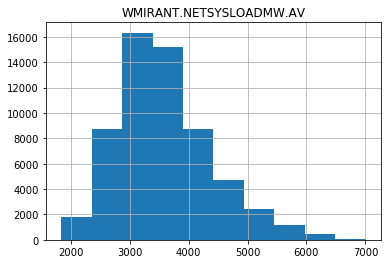

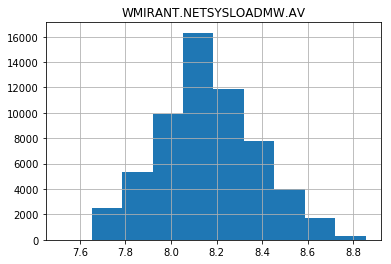

In [21]:
# Show the distribution of y and log(y)
y.hist()
y_log.hist()

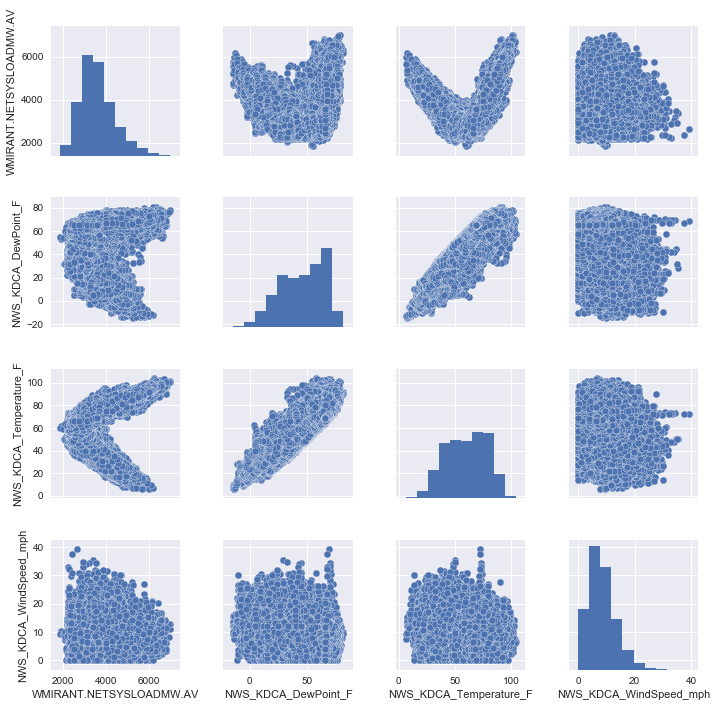

In [49]:
sns.pairplot(df)

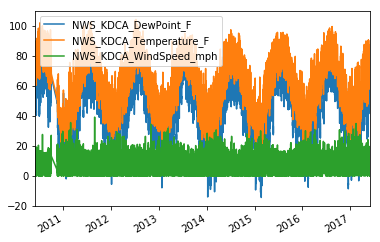

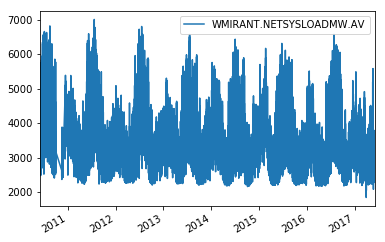

In [22]:
# Plot the X and y values to get an idea of what they look like
X.plot()
y.plot()

## Split the Data into a train and test set

In [23]:
train_len = int(X.shape[0]*(2/3)) # 2/3 of the sample as train
test_len = int(X.shape[0]*(1/3)) # 1/3 of the sample as test

X_train = X.head(train_len)
y_train = y.head(train_len)
X_test = X.tail(test_len)
y_test = y.tail(test_len)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [24]:
# Verify shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train_log.shape)
print(y_test_log.shape)

(39808, 3)
(19904, 3)
(39808, 1)
(19904, 1)
(39808, 1)
(19904, 1)


In [25]:
# Ignore the warnings (They get annoying)
import warnings
warnings.filterwarnings('ignore')

## Feature Engineering Classes

These classes are called upon from the Pipeline to create features that will be used by the model. Features that are added include- day of week, weekend/weekday, month, hour, temp squared, holidays, etc.

In [26]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from sklearn.base import BaseEstimator, TransformerMixin

import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

class PipelineEstimator(BaseEstimator, TransformerMixin):
    """Define the necessary methods"""

    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        return X

    
class YearTransformer(PipelineEstimator):
    """Parse datetime and pull year"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        self.earliest_date = np.min(X.index.date)
        return self

    def transform(self, X, y = None):
        year = pd.DataFrame(X.index.year)
        return year
    
class MonthTransformer(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        self.earliest_date = np.min(X.index.date)
        return self

    def transform(self, X, y = None):
        moy = pd.DataFrame(X.index.month)
        return moy

class DayofMonthTransformer(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        self.earliest_date = np.min(X.index.date)
        return self

    def transform(self, X, y = None):
        dom = pd.DataFrame(X.index.day)
        return dom
    
class HourOfDayTransformer(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        self.earliest_date = np.min(X.index.date)
        return self

    def transform(self, X, y = None):
        hod = pd.DataFrame(X.index.hour)
        return hod

class DayofWeekTransformer(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        self.earliest_date = np.min(X.index.date)
        return self

    def transform(self, X, y = None):
        dow = pd.DataFrame(X.index.weekday)
        return dow
    
class HourDummies(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        self.earliest_date = np.min(X.index.date)
        return self

    def transform(self, X, y = None):
        """Create Dummy Variables."""
        cat = pd.Categorical(X.index.hour, categories=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
        hourdummies = pd.get_dummies(pd.DataFrame({"cat":cat}),prefix='hour', drop_first=True)
        return hourdummies
    
class MonthDummies(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        self.earliest_date = np.min(X.index.date)
        return self

    def transform(self, X, y = None):
        """Create Dummy Variables."""
        cat = pd.Categorical(X.index.hour, categories=[0,1,2,3,4,5,6,7,8,9,10,11])
        monthdummies = pd.get_dummies(pd.DataFrame({"cat":cat}),prefix='month', drop_first=True)
        return monthdummies
    
class WeekdayDummies(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        self.earliest_date = np.min(X.index.date)
        return self

    def transform(self, X, y = None):
        """Create Dummy Variables."""
        cat = pd.Categorical(X.index.weekday, categories=[0,1,2,3,4,5,6])
        weekdaydummies = pd.get_dummies(pd.DataFrame({"cat":cat}),prefix='weekday', drop_first=True)
        return weekdaydummies

class SquareTemp(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        """Create Squared Variables."""
        return pd.DataFrame(np.square(X['NWS_KDCA_Temperature_F']))
    
class SquareWindspeed(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        """Create Squared Variables."""
        return pd.DataFrame(np.square(X['NWS_KDCA_WindSpeed_mph']))
    
    
class WeekdayWeekend(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        """Create Squared Variables."""
        weekendweekday = ((pd.DatetimeIndex(X.index).dayofweek) // 5 == 1).astype(float)
        weekendweekday = pd.DataFrame(weekendweekday)
        return weekendweekday

class HolidayBinary(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        """Create Squared Variables."""
        cal = calendar()
        holidays = cal.holidays(start='2000-01-01', end='2050-01-01')
        holiday_bin_temp = pd.DataFrame(X.index.date, index=X.index, columns=['date'])
        holiday_bin = holiday_bin_temp['date'].astype('datetime64').isin(holidays)
        holiday_bin = pd.DataFrame(holiday_bin)
        del holiday_bin_temp
        return holiday_bin

class TransformedDetails(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        self.earliest_date = None

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        """Create Squared Variables."""
        X = pd.DataFrame(X)
        print(X.shape)
        print(X.describe())
        return
    
class FeatureStats(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, y=None):
        print("size = ", X.shape[1])
        return X

    def fit(self, X, y=None):
        return self
    
class TempChangeLast(PipelineEstimator):
    def __init__(self, use = True):
        pass

    def transform(self, X, y = None):
        
        temp_change_bk = (X['NWS_KDCA_Temperature_F'].shift() - X['NWS_KDCA_Temperature_F']).fillna(0)
        return pd.DataFrame(temp_change_bk)

class TempChangeNext(PipelineEstimator):
    def __init__(self, use = True):
        pass
        
    def transform(self, X, y = None):
        temp_change_fwd = (X['NWS_KDCA_Temperature_F'].shift(-1) - X['NWS_KDCA_Temperature_F']).fillna(0)
        return pd.DataFrame(temp_change_fwd)

# Pipeline

A pipeline allows us to streamline the process of transforming the data and fitting a model. It allows us to easily repeat the process against our train and test splits. It also allows us to quickly remove transformations or swap out model types to see how it impacts model accuracy.

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
pipeline = Pipeline([
    ('features', FeatureUnion(
                transformer_list=[
                ('Hour of Day', HourOfDayTransformer()),
                ('Day of Week', DayofWeekTransformer()),
                ('Month_of_year', MonthTransformer()),
                ('Day_of_month', DayofMonthTransformer()),
                ('Year', YearTransformer()),
                ('hour dummies',HourDummies()),
                ('month dummies',MonthDummies()),
                ('weekday dummies',WeekdayDummies()),
                ('square temp', SquareTemp()),
                ('square windspeed', SquareWindspeed()),
                ('Weekday weekend', WeekdayWeekend()),
                ('Holiday Binary', HolidayBinary()),
                ('StandardScaler', StandardScaler()),
                ('Temp Change Last', TempChangeLast()),
                ('Temp Change Next', TempChangeNext())
            ])
     ),
        ('estimator', RandomForestRegressor(n_estimators=300))
    ])

## Train the Model on the train set

Depending on the size of your data and your computer processor, the training may take some time.

In [28]:
# Train the test set
pipeline.fit(X_train, y_train_log)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('Hour of Day', HourOfDayTransformer()), ('Day of Week', DayofWeekTransformer()), ('Month_of_year', MonthTransformer()), ('Day_of_month', DayofMonthTransformer()), ('Year', YearTransformer()), ('hour dummies', HourDummies()), ('mont...imators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

## Parameter Tuning
We can use the `GridSearchCV` function to identify the best parameters to use when creating our model.

In this case we know a random forest regressor typically works well with a larger number of `n_estimators`.

In [29]:
tuned_parameters = {'n_estimators': [500, 700, 1000], 'max_depth': [None, 1, 2, 3], 'min_samples_split': [1, 2, 3]}
clf = GridSearchCV(pipeline, tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

In [74]:
### WARNING, RUNNING THIS CELL WILL TAKE A LONG TIME ###

## UNCOMMENT AND RUN IF YOU WANT TO PARAMETER TUNE
#clf.train(X_train, y_train_log)

## Make Predictions on the Train and Test set and score error
We can now use this model to predict on our train and test sets. We will use the mean squared error to judge if our model fits our test data well.

In [31]:
# Create our training predictions
train_predictions = pd.DataFrame(np.exp(pipeline.predict(X_train)), index=X_train.index, columns=['Predictions'])
train_predictions_log = pd.DataFrame(pipeline.predict(X_train), index=X_train.index, columns=['Predictions_log'])
train_predictions.head()

,Predictions
2010-06-01 01:00:00,3697.848720
2010-06-01 02:00:00,3434.605690
2010-06-01 03:00:00,3298.891732
2010-06-01 04:00:00,3229.448254
2010-06-01 05:00:00,3202.838139


In [32]:
# MSE of the train set. We expect this to be low because it is the data we trained the model on
mean_squared_error(y_train_log, train_predictions_log)

0.00014514882883055885

In [33]:
test_predictions = pd.DataFrame(np.exp(pipeline.predict(X_test)), index=X_test.index, columns=['Predictions'])
test_predictions_log = pd.DataFrame(pipeline.predict(X_test), index=X_test.index, columns=['Predictions_log'])
# MSE of the modeal against the test set
mean_squared_error(y_test_log, test_predictions_log)

0.0029826774092377144

## Show the worst predicted hours
By comparing our predictions with the actual test set data we can see which hours our model predicted the worst on. Even though the model accounts for holidays, the worst predictions appear to show on holidays. This may improve once we create our final model which uses the entire data set.

In [34]:
compare_test_preds = test_predictions
# Join predictions with actuals into a dataframe
compare_test_preds = pd.concat([test_predictions, y_test], axis=1)
# Create a difference column
compare_test_preds['Difference'] = np.abs(compare_test_preds['Predictions'] - compare_test_preds['WMIRANT.NETSYSLOADMW.AV'])
# Sort by worst prediction
compare_test_preds = compare_test_preds.sort('Difference', ascending=False)
# Print the first 10 rows
compare_test_preds.head(10)

,Predictions,WMIRANT.NETSYSLOADMW.AV,Difference
2016-07-04 08:00:00,3783.126719,2794.688770,988.437949
2016-07-04 09:00:00,3938.571342,2950.690896,987.880446
2017-05-29 08:00:00,3490.757324,2581.762859,908.994465
2017-05-29 12:00:00,4068.971573,3204.596687,864.374886
2015-06-27 19:00:00,4343.356579,3505.561688,837.794891
2015-07-03 09:00:00,3876.233457,3046.463754,829.769703
2016-07-04 10:00:00,3956.255846,3127.724890,828.530956
2015-12-25 10:00:00,3655.010900,2841.676954,813.333946
2016-05-30 09:00:00,3878.624106,3078.620370,800.003736
2016-05-30 08:00:00,3684.376774,2888.901501,795.475274


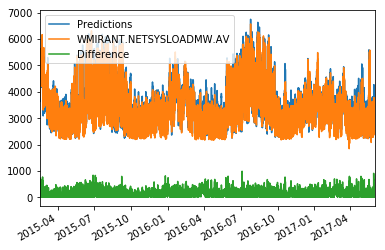

In [35]:
compare_test_preds.plot()

## If you want to store the results as a CSV uncomment the line below
## compare_test_preds.to_csv('test_predictions.csv')

## Train our best model on the entire dataset
Once we have found our best model we will train the model on the entire dataset. There is no reason to ignore our test data at this point and our model will gain accuracy from the additional observations.

In [36]:
pipeline.fit(X, y_log)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('Hour of Day', HourOfDayTransformer()), ('Day of Week', DayofWeekTransformer()), ('Month_of_year', MonthTransformer()), ('Day_of_month', DayofMonthTransformer()), ('Year', YearTransformer()), ('hour dummies', HourDummies()), ('mont...imators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [50]:
# Predict on our entire dataset using our complete model
predictions = pd.DataFrame(np.exp(pipeline.predict(X)), index=X.index, columns=['Predictions'])
predictions_log = pd.DataFrame(pipeline.predict(X), index=X.index, columns=['Predictions_log'])
# MSE of the modeal against the test set
mean_squared_error(y_log, predictions_log)

0.00015072822010153743

In [51]:
# Show worst days
compare_preds = predictions
# Join predictions with actuals into a dataframe
compare_preds = pd.concat([predictions, y], axis=1)
# Create a difference column
compare_preds['Difference'] = np.abs(compare_preds['Predictions'] - compare_preds['WMIRANT.NETSYSLOADMW.AV'])
# Sort by worst prediction
compare_preds = compare_preds.sort('Difference', ascending=False)
# Print the first 10 rows
compare_preds.head(10)

,Predictions,WMIRANT.NETSYSLOADMW.AV,Difference
2012-09-28 05:00:00,3643.825744,4181.186475,537.360731
2012-09-28 06:00:00,3671.230721,4192.031177,520.800456
2010-08-17 18:00:00,6299.037548,6787.769817,488.732269
2010-09-30 14:00:00,5292.134467,5766.655474,474.521006
2012-06-30 21:00:00,4360.535490,3920.017504,440.517986
2012-06-30 11:00:00,3700.406975,3265.490338,434.916637
2012-06-30 20:00:00,4348.395553,3914.874704,433.520848
2012-06-30 12:00:00,3743.101321,3312.635419,430.465902
2012-06-30 16:00:00,4301.104886,3892.616927,408.487959
2010-08-17 17:00:00,6407.002559,6815.450071,408.447512


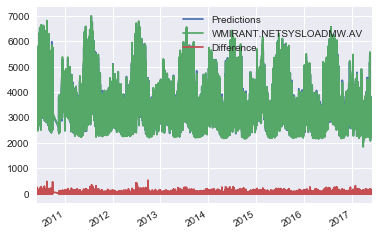

In [52]:
compare_preds.plot()
#compare_preds.to_csv('predictions.csv')

# Pull Weather Forecast Data and Format

In [53]:
weather_forecast_tags = ['NWS_KDCA_DewPoint_F.Forecast','NWS_KDCA_Temperature_F.Forecast','NWS_KDCA_WindSpeed_mph.Forecast']
start ='t'
end = 't+7d'
freq = '1h'
summarytype = AFSummaryTypes.Average
X_future = Pull_Multi_PIData(weather_forecast_tags, start, end, freq, complete_cases=True, summarytype=summarytype)

In [56]:
# Remove the .Forecast from the PI tag name to make it fit with model names
def rename_forecast_cols(df):
    new_colnames = []
    for col in X_future.columns:
        new_colnames.append((col.split(".")[0]))
    df.columns = new_colnames
    return df

In [57]:
X_future = rename_forecast_cols(X_future)

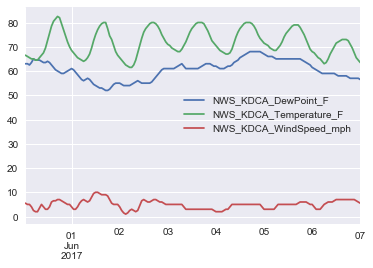

In [58]:
X_future.plot()

# Store Data Back in PI
Finally we create a function which will store our results back into a PI point.

In [59]:
def Store_Preds(df, valuecol, pointname):
    '''Function for storing values from a dataframe back into PI. Index of the dataframe needs to be in 
    datetime format'''
    df.rename(columns = {valuecol:'vals'}, inplace = True)
    df.head()
    writept = PIPoint.FindPIPoint(piServer,pointname)
    writeptname = writept.Name.lower()
    
    for row in df.itertuples():
        val = AFValue()
        val.Value = float(row.vals)
        time = AFTime(str(row.Index))
        val.Timestamp = time
        writept.UpdateValue(val, AFUpdateOption.Replace, AFBufferOption.BufferIfPossible)

In [60]:
fut_predictions = pd.DataFrame(np.exp(pipeline.predict(X_future)), index=X_future.index, columns=['Future_Predictions'])

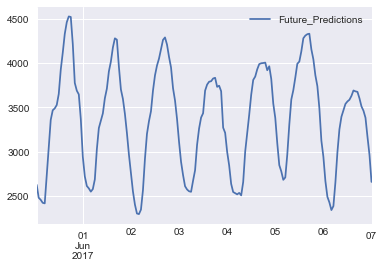

In [61]:
fut_predictions.plot()

In [62]:
# Uncomment the below to store the predictions in a PI point

#StorePIPointName = 'Test_Forecast_Point'
#Store_Preds(fut_predictions, valuecol='Future_Predictions',pointname=StorePIPointName)